In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB


# Load Data

In [2]:
df = pd.read_csv('w5000.csv')

# Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np

# Load data (replace with your local path)
df = pd.read_csv("w5000.csv")

# Keep only the closing‑price columns (skip the first 3 ID columns)
price_df = df.iloc[:, 3:]
 
# Drop assets with any missing prices
price_df = price_df.dropna(axis=1)

# Daily returns
returns = price_df.pct_change().dropna()  # Computes daily return rates for each asset.

# Outlier rule and max fixes per asset
threshold   = 0.25   # ±25 %
fix_limit   = 20     # skip asset if >20 fixes are needed

cleaned = {}

'''
Outlier Filtering:
For each asset, if the absolute return exceeds 25%, it's considered an outlier.
If an asset has more than 20 such days, it’s discarded.
Otherwise, outliers are replaced by the mean of nearby non-outlier values within a 5-day window.
'''
for col in returns.columns:
    series   = returns[col].copy()
    outliers = series[series.abs() > threshold]

    # Skip asset if too many extreme moves
    if len(outliers) > fix_limit:
        continue

    # Replace each outlier with the mean of a 5‑day local window
    for idx in outliers.index:
        if 2 <= idx <= len(series) - 3:
            window = series[idx - 2 : idx + 3]
            local  = window[window.abs() <= threshold]
            if len(local):
                series[idx] = local.mean()

    cleaned[col] = series

# Return matrix after cleaning
returns_cleaned = pd.DataFrame(cleaned)

# Mean vector and covariance matrix
mu = returns_cleaned.mean().values  # mu: Mean return for each asset (used for expected return in optimization).
Q  = returns_cleaned.cov().values  # Q: Covariance matrix of cleaned returns (used for risk estimation).

print(f"Number of valid assets : {returns_cleaned.shape[1]}")
print(f"Mean vector shape      : {mu.shape}")
print(f"Covariance matrix shape: {Q.shape}")


Number of valid assets : 2034
Mean vector shape      : (2034,)
Covariance matrix shape: (2034, 2034)


# Optimization Model

In [ ]:
import gurobipy as gp
from gurobipy import GRB
from sklearn.decomposition import PCA
import numpy as np

# user‑defined parameters
risk_aversion = 1_000           # λ in the objective： Risk aversion factor 
u = 0.05                        # max absolute weight per asset： Bounds on individual asset weights 
d = 0.0001                      # min non‑zero weight： Bounds on individual asset weights 
L, U   = 30, 60                 # # of long positions  ∈ [L, U] ： Cardinality constraints for long positions 
S_L, S_U = 30, 60               # # of short positions ∈ [S_L, S_U] ： Cardinality constraints for short positions 
f, g   = 0.1, 0.3               # total long weight   ∈ [f, g] ： Gross exposure limits 
h, i   = 0.1, 0.3               # total short weight  ∈ [h, i] ： Gross exposure limits 

assets   = returns_cleaned.columns.tolist()
n        = len(assets)
mu_vec   = mu                   # mean vector (numpy)
Q_matrix = Q                    # full covariance

# PCA approximation of the covariance (first 50 factors)
pca      = PCA(n_components=50).fit(returns_cleaned)  # Uses the top 50 principal components to approximate the covariance matrix.
pca_cov  = pca.components_.T @ np.diag(pca.explained_variance_) @ pca.components_

# build Gurobi model
m = gp.Model("mean_variance_portfolio")

# decision variables
'''
Each asset weight x[j] is expressed as the difference between long (p[j]) and short (m_[j]) components. Binary variables enforce sparsity.
'''
p  = m.addVars(n, lb=0,    ub=u, name="p")          # long leg
m_ = m.addVars(n, lb=0,    ub=u, name="m")          # short leg (absolute)
zp = m.addVars(n, vtype=GRB.BINARY, name="zp")      # long flag
zm = m.addVars(n, vtype=GRB.BINARY, name="zm")      # short flag
x  = m.addVars(n, lb=-u,   ub=u, name="x")          # net weight  x = p - m_

# link variables and enforce |x| >= d if active
'''
Constraint: each asset can either be long or short or inactive. If active, its absolute value must lie within [d, u].
'''
for j in range(n):
    m.addConstr(x[j] == p[j] - m_[j])
    m.addConstr(zp[j] + zm[j] <= 1)                 # mutually exclusive

    m.addConstr(p[j]  <= u * zp[j])
    m.addConstr(p[j]  >= d * zp[j])

    m.addConstr(m_[j] <= u * zm[j])
    m.addConstr(m_[j] >= d * zm[j])

# cardinality constraints
m.addConstr(gp.quicksum(zp[j] for j in range(n)) >= L)  # at least L assets must be held long (because each zp[j] is 1 if asset j is in the long book, 0 otherwise).
m.addConstr(gp.quicksum(zp[j] for j in range(n)) <= U) # no more than U long positions are allowed.
m.addConstr(gp.quicksum(zm[j] for j in range(n)) >= S_L) # at least S_L assets must be held short.
m.addConstr(gp.quicksum(zm[j] for j in range(n)) <= S_U) # no more than S_U short positions are allowed.

# gross exposure constraints
m.addConstr(gp.quicksum(p[j]  for j in range(n)) >= f) # the total weight of all long legs p[j] must be at least f.
m.addConstr(gp.quicksum(p[j]  for j in range(n)) <= g) # the total long weight cannot exceed g.


m.addConstr(gp.quicksum(m_[j] for j in range(n)) >= h) # the total absolute short weight m_[j] must be at least h.
m.addConstr(gp.quicksum(m_[j] for j in range(n)) <= i) # the total short weight cannot exceed i

# objective: minimize risk-adjusted return (λ·risk  –  expected return) [λ⋅Variance−Expected Return]
risk_term = gp.quicksum(x[i] * pca_cov[i, j] * x[j]
                        for i in range(n) for j in range(n))
return_term = gp.quicksum(mu_vec[j] * x[j] for j in range(n))
m.setObjective(risk_aversion * risk_term - return_term, GRB.MINIMIZE)

# solve
m.optimize()

# grab optimal weights
if m.status == GRB.OPTIMAL:  #This checks if the model was solved successfully. 
    x_opt = np.array([x[j].X for j in range(n)])  # Extracts the final portfolio weights (x[j].X) into x_opt

    # calculate expected return
    portfolio_expected_return = np.dot(mu_vec, x_opt)

    print(f"Number of selected assets: {np.sum(np.abs(x_opt) > 1e-6)}\n") 

    for j in range(n):
        if abs(x_opt[j]) > 1e-6:
            print(assets[j], x_opt[j])

    print("\nPortfolio Expected Return:", portfolio_expected_return)

else:
    raise ValueError("Model infeasible")


Set parameter Username
Set parameter LicenseID to value 2642225
Academic license - for non-commercial use only - expires 2026-03-25
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12212 rows, 10170 columns and 42714 nonzeros
Model fingerprint: 0x3be04892
Model has 2069595 quadratic objective terms
Variable types: 6102 continuous, 4068 integer (4068 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [4e-07, 4e-03]
  QObjective range [3e-06, 5e+00]
  Bounds range     [5e-02, 1e+00]
  RHS range        [1e-01, 6e+01]
Found heuristic solution: objective 0.0009450
Presolve removed 2 rows and 0 columns
Presolve time: 0.20s
Presolved: 12210 rows, 10172 columns, 38648 nonzeros
Presolved model has 2069595 quadratic objective terms
Variable types: 6104 continuous, 4068 integer (4068 binary)

Root simplex log..

# Stimulation

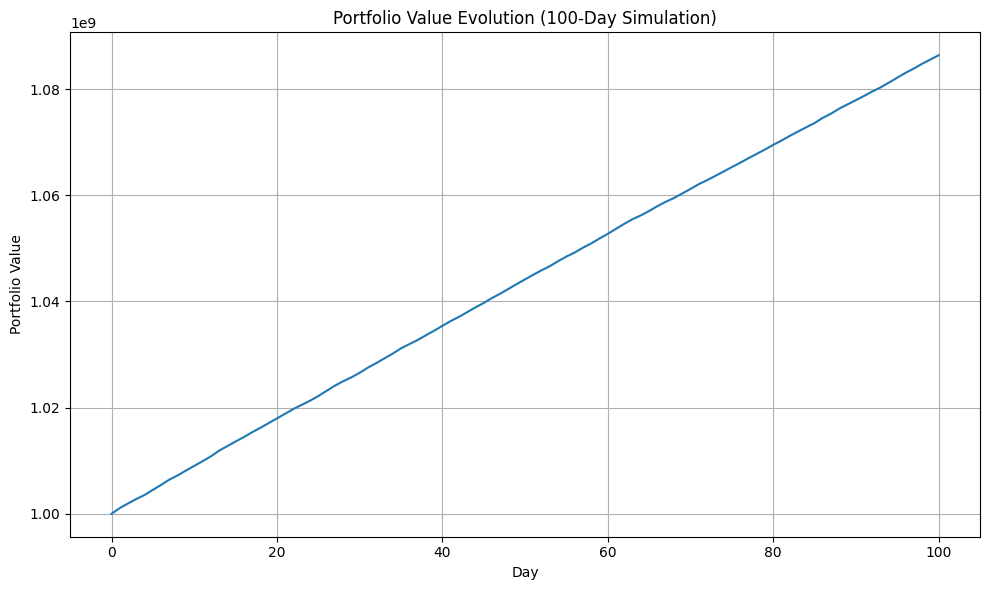

In [ ]:
initial_value = 1e9            # Initializes the portfolio with $1B and converts weights into share quantities. Keeps leftover cash uninvested.

# position sizes (shares can be positive or negative)
initial_prices = price_df[returns_cleaned.columns].iloc[-1].values
shares   = (x_opt * initial_value) / initial_prices
net_wgt  = np.sum(x_opt)

# leftover cash
cash = initial_value * (1 - net_wgt)

# check we really start at 1 B
assert np.isclose(cash + np.dot(shares, initial_prices), initial_value, atol=1e-2)

# simulate 100 days
prices = initial_prices.copy()
portfolio_values = [initial_value]

d_std = np.sqrt(np.diag(Q_matrix))
d_cap = np.minimum(d_std, np.abs(mu_vec / 2))


'''
Simulates asset prices for 100 days using uniformly sampled returns around the mean. The portfolio value is recalculated daily.
'''
for _ in range(100):
    shocks  = np.random.uniform(mu_vec - d_cap, mu_vec + d_cap)
    prices *= (1 + shocks)
    portfolio_values.append(cash + np.dot(shares, prices))

# plot
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values)
plt.xlabel("Day")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Evolution (100‑Day Simulation)")
plt.grid(True)
plt.tight_layout()
plt.show()
